In [1]:
import pandas as pd
import numpy as np
from tqdm import trange, tqdm
import scipy as sc
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm.contrib import tzip

In [24]:
#path
DATA_PATH = "data/wikispeedia_paths-and-graph/"

In [62]:
df_finished_paths = pd.read_csv(DATA_PATH + "paths_finished.tsv", sep="\t", header = None, skiprows=15, names = [
    'hashedIpAddress',   'timestamp',   'durationInSec',   'path',   'rating',
  ])
df_finished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [26]:
df_unfinished_paths = pd.read_csv(DATA_PATH + "paths_unfinished.tsv", sep="\t", header = None, skiprows=16, names = [
    'hashedIpAddress',   'timestamp',   'durationInSec',   'path',   'target'   ,'type'
  ])
df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


# Find the mistake (TEVA)

# Behavioral analysis

In [6]:
print(np.shape(df_finished_paths))
print(np.shape(df_unfinished_paths))

(51318, 5)
(24875, 6)


In [8]:
df_finished_paths['nbr_win'] = df_finished_paths.groupby('hashedIpAddress')['hashedIpAddress'].transform('count')
df_finished_paths.head(20)

,hashedIpAddress,timestamp,durationInSec,path,rating,nbr_win
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,4.0
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,13.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,43.0
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,3.0
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,8.0
5,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN,13.0
6,36dabfa133b20e3c,1249525912,112,14th_century;China;Gunpowder;Fire,2.0,2.0
7,20418ff4797f96be,1229188046,139,14th_century;Time;Isaac_Newton;Light;Color;Rai...,1.0,7.0
8,08888b1b428dd90e,1232241510,74,14th_century;Time;Light;Rainbow,3.0,33.0
9,08888b1b428dd90e,1232241601,167,14th_century;15th_century;Plato;Nature;Ultravi...,NaN,33.0


In [9]:
df_unfinished_paths['nbr_loss'] = df_unfinished_paths.groupby('hashedIpAddress')['hashedIpAddress'].transform('count')
df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,nbr_loss
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,1
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,1
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,1
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2


In [10]:
"""#test = df_finished_paths[["hashedIpAddress","nbr_win"]].drop_duplicates()
ddf_nbr_games = df_finished_paths[["hashedIpAddress","nbr_win"]].drop_duplicates().merge(df_unfinished_paths[['hashedIpAddress','nbr_loss']].drop_duplicates(),
                          how = "inner",
                          on="hashedIpAddress")
ddf_nbr_games.head(100000)"""

'#test = df_finished_paths[["hashedIpAddress","nbr_win"]].drop_duplicates()\nddf_nbr_games = df_finished_paths[["hashedIpAddress","nbr_win"]].drop_duplicates().merge(df_unfinished_paths[[\'hashedIpAddress\',\'nbr_loss\']].drop_duplicates(),\n                          how = "inner",\n                          on="hashedIpAddress")\nddf_nbr_games.head(100000)'

In [11]:
df_nbr_games = df_finished_paths[["hashedIpAddress",'nbr_win']].drop_duplicates().merge(df_unfinished_paths[['hashedIpAddress','nbr_loss']].drop_duplicates(),
                                                                                        how = "outer",
                                                                                        on="hashedIpAddress")
df_nbr_games = df_nbr_games.fillna(0)
df_nbr_games['nbr_play'] = df_nbr_games['nbr_win'] + df_nbr_games['nbr_loss']
df_nbr_games.head(20)

,hashedIpAddress,nbr_win,nbr_loss,nbr_play
0,6a3701d319fc3754,4.0,4.0,8.0
1,3824310e536af032,13.0,8.0,21.0
2,415612e93584d30e,43.0,37.0,80.0
3,64dd5cd342e3780c,3.0,0.0,3.0
4,015245d773376aab,8.0,0.0,8.0
5,5295bca242be81fe,13.0,7.0,20.0
6,36dabfa133b20e3c,2.0,0.0,2.0
7,20418ff4797f96be,7.0,0.0,7.0
8,08888b1b428dd90e,33.0,0.0,33.0
9,4cb0068c36658716,1.0,0.0,1.0


In [12]:
#print(reg.intercept_, reg.coef_, reg.score(np.array(df_lim100['nbr_loss']).reshape(-1, 1),df_lim100['nbr_play']))

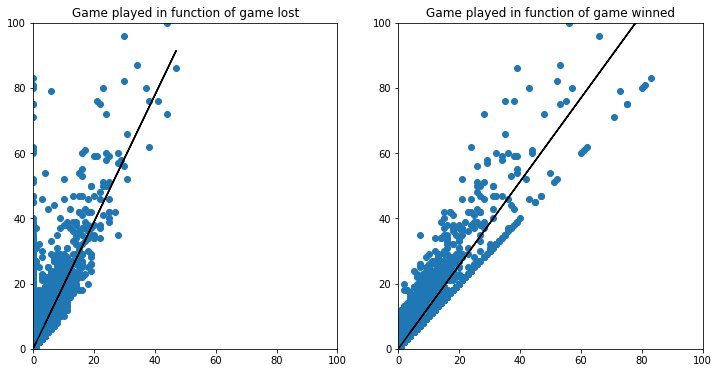

In [13]:
fig,axs = plt.subplots(1,2,figsize = (12,6))

df_lim100 = df_nbr_games[df_nbr_games["nbr_play"]<=100]

regression_loss = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['nbr_loss']).reshape(-1, 1),df_lim100['nbr_play'])
axs[0].plot(df_lim100['nbr_loss'],regression_loss.predict(np.array(df_lim100['nbr_loss']).reshape(-1, 1)),'-k')

regression_win = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['nbr_win']).reshape(-1, 1),df_lim100['nbr_play'])
axs[1].plot(df_lim100['nbr_win'],regression_win.predict(np.array(df_lim100['nbr_win']).reshape(-1, 1)),'-k')

axs[0].scatter(df_nbr_games['nbr_loss'],df_nbr_games['nbr_play'])
axs[0].set_title("Game played in function of game lost")
axs[0].set_ylim((0,100))
axs[0].set_xlim((0,100))


axs[1].scatter(df_nbr_games['nbr_win'],df_nbr_games['nbr_play'])
axs[1].set_title("Game played in function of game winned")
axs[1].set_xlim((0,100))
axs[1].set_ylim((0,100))


plt.show()

In [14]:
coeff_loss = regression_loss.coef_[0]
R2_loss = regression_loss.score(np.array(df_lim100['nbr_loss']).reshape(-1, 1),df_lim100['nbr_play'])
coeff_win = regression_win.coef_[0]
R2_win = regression_win.score(np.array(df_lim100['nbr_win']).reshape(-1, 1),df_lim100['nbr_play'])
print('Coefficient loss: %.2f \n R^2 loss: %.5f' % (coeff_loss,R2_loss))
print('Coefficient win: %.2f \n R^2 win: %.5f'% (coeff_win,R2_win))
print('mean number of game per player: %.2f'%(df_nbr_games['nbr_play'].mean()))

Coefficient loss: 1.94 
 R^2 loss: 0.46341
Coefficient win: 1.28 
 R^2 win: 0.83998
mean number of game per player: 3.65


In [15]:
print("Players discarded when reducing to 100 game played: %.f" %(np.shape(df_nbr_games)[0]-np.shape(df_lim100)[0]))

Players discarded when reducing to 100 game played: 23


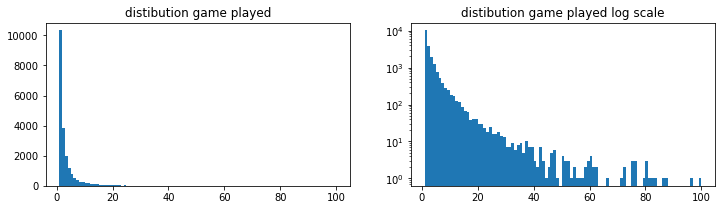

In [16]:
fig,axs = plt.subplots(1,2,figsize = (12,3))

axs[0].hist(df_lim100["nbr_play"],bins = np.arange(1,101,1))
axs[0].set_title("distibution game played")
axs[1].hist(df_lim100["nbr_play"],bins = np.arange(1,101,1))
axs[1].set_title("distibution game played log scale")
axs[1].set_yscale("log")
#axs[1].set_xscale("log")
plt.show()

In [17]:
#Paired t-test (because non-normal distributed data):
p_ttest = sc.stats.ttest_rel(df_lim100["nbr_play"], coeff_loss*df_lim100["nbr_loss"])
#print("The p-value of the Paired t-test is %.E and the t-statistic value: %.1f, we thus reject the null hypothesis" % (p_ttest[1], p_ttest[0]))
print(p_ttest)

Ttest_relResult(statistic=37.47885542892898, pvalue=1.448430244676751e-297)


In [18]:
#look in cft of time:
df_finished_paths['time_spent_winning'] = df_finished_paths.groupby('hashedIpAddress')['durationInSec'].transform('sum')

df_unfinished_paths['time_spent'] = df_unfinished_paths.groupby('hashedIpAddress')['durationInSec'].transform('sum')
df_unfinished_paths['nbr_timeout'] = df_unfinished_paths[df_unfinished_paths['type']=='timeout'].groupby('hashedIpAddress')['type'].transform('count')
df_unfinished_paths['nbr_timeout'] = df_unfinished_paths.groupby('hashedIpAddress')['nbr_timeout'].transform('mean')
df_unfinished_paths = df_unfinished_paths.fillna(0)
df_unfinished_paths['time_spent_losing'] = df_unfinished_paths['time_spent'] - df_unfinished_paths['nbr_timeout'] * 1800 
#4 times the timeout happened before 30min, leading to a negative time sprent, put those numbers back to 0.
df_unfinished_paths[df_unfinished_paths['time_spent_losing']<0] = 0
df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,nbr_loss,time_spent,nbr_timeout,time_spent_losing
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,1,1804,1.0,4.0
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,1,1805,1.0,5.0
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,1,1818,1.0,18.0
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2,1857,1.0,57.0
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2,1857,1.0,57.0


In [19]:
df_time_games = df_finished_paths[["hashedIpAddress",'time_spent_winning']].drop_duplicates().merge(
                                                                                        df_unfinished_paths[['hashedIpAddress','time_spent_losing']].drop_duplicates(),
                                                                                        how = "outer",
                                                                                        on="hashedIpAddress")
df_time_games = df_time_games.fillna(0)
df_time_games["time_played"] = df_time_games['time_spent_winning'] + df_time_games['time_spent_losing']

df_nbr_games = df_nbr_games.merge(df_time_games, how="outer", on="hashedIpAddress")
df_nbr_games = df_nbr_games.fillna(0)
df_nbr_games.head()

,hashedIpAddress,nbr_win,nbr_loss,nbr_play,time_spent_winning,time_spent_losing,time_played
0,6a3701d319fc3754,4.0,4.0,8.0,783.0,644.0,1427.0
1,3824310e536af032,13.0,8.0,21.0,1300.0,1287.0,2587.0
2,415612e93584d30e,43.0,37.0,80.0,3083.0,3601.0,6684.0
3,64dd5cd342e3780c,3.0,0.0,3.0,277.0,0.0,277.0
4,015245d773376aab,8.0,0.0,8.0,1535.0,0.0,1535.0


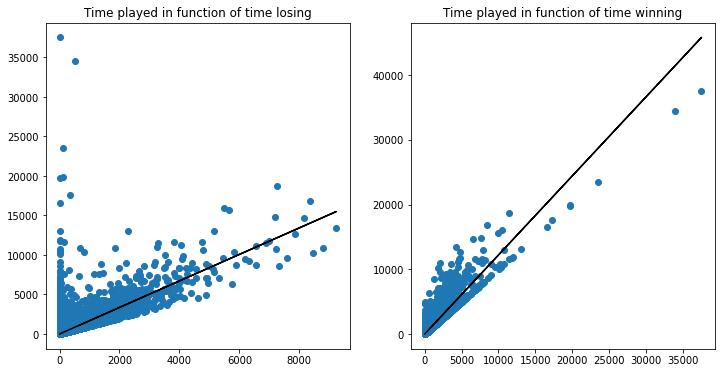

In [20]:
fig,axs = plt.subplots(1,2,figsize = (12,6))

df_lim100 = df_nbr_games[df_nbr_games["nbr_play"]<=100]

regression_loss_t = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['time_spent_losing']).reshape(-1, 1),df_lim100['time_played'])
axs[0].plot(df_lim100['time_spent_losing'],regression_loss_t.predict(np.array(df_lim100['time_spent_losing']).reshape(-1, 1)),'-k')

regression_win_t = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['time_spent_winning']).reshape(-1, 1),df_lim100['time_played'])
axs[1].plot(df_lim100['time_spent_winning'],regression_win_t.predict(np.array(df_lim100['time_spent_winning']).reshape(-1, 1)),'-k')

axs[0].scatter(df_lim100['time_spent_losing'],df_lim100['time_played'])
axs[0].set_title("Time played in function of time losing")
#axs[0].set_ylim((0,100))
#axs[0].set_xlim((0,100))


axs[1].scatter(df_lim100['time_spent_winning'],df_lim100['time_played'])
axs[1].set_title("Time played in function of time winning")
#axs[1].set_xlim((0,100))
#axs[1].set_ylim((0,100))


plt.show()

In [21]:
coeff_loss_t = regression_loss_t.coef_[0]
R2_loss_t = regression_loss_t.score(np.array(df_lim100['time_spent_losing']).reshape(-1, 1),df_lim100['time_played'])
coeff_win_t = regression_win_t.coef_[0]
R2_win_t = regression_win_t.score(np.array(df_lim100['time_spent_winning']).reshape(-1, 1),df_lim100['time_played'])
print('Coefficient loss: %.2f \n R^2 loss: %.5f' % (coeff_loss_t,R2_loss_t))
print('Coefficient win: %.2f \n R^2 win: %.5f'% (coeff_win_t,R2_win_t))
print('mean time of game per player: %.2f s'%(df_nbr_games['time_played'].mean()))
print('mean time of one game: %.2f s'%(1/2*df_unfinished_paths['durationInSec'].mean()+1/2*df_finished_paths['durationInSec'].mean()))

Coefficient loss: 1.68 
 R^2 loss: 0.41239
Coefficient win: 1.22 
 R^2 win: 0.80860
mean time of game per player: 580.74 s
mean time of one game: 496.62 s


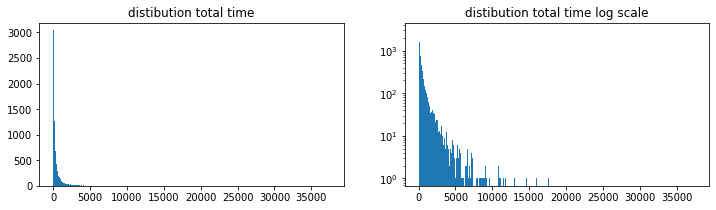

In [22]:
fig,axs = plt.subplots(1,2,figsize = (12,3))

axs[0].hist(df_lim100["time_played"],bins = 1000)
axs[0].set_title("distibution total time")
#axs[0].set_xlim([0,500])
axs[1].hist(df_lim100["time_played"],bins = 1000)
axs[1].set_title("distibution total time log scale")
axs[1].set_yscale("log")
#axs[1].set_xscale("log")
plt.show()

# Temporal analysis

In [39]:
# create dataframe with all path
all_paths = pd.concat([df_finished_paths.iloc[:, :4], df_unfinished_paths.iloc[:, :4]], ignore_index=True)
# sorted by temporal order
all_paths.sort_values(by="timestamp", inplace=True)

In [40]:
# extract datetime of the path year/ month/ day and hour
all_paths["timestamp"] = [datetime.fromtimestamp(x).strftime("%m,%d,%Y,%I:%M:%S") for x in all_paths["timestamp"]]
all_paths["year"] = [x.split(",")[2] for x in all_paths["timestamp"]]
all_paths["month"] = [x.split(",")[0] for x in all_paths["timestamp"]]
all_paths["day"] = [x.split(",")[1] for x in all_paths["timestamp"]]
all_paths["hour"] = [x.split(",")[3] for x in all_paths["timestamp"]]
all_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,year,month,day,hour
15545,NaN,"08,18,2008,11:29:32",106,Tropical_Storm_Bonnie_%282004%29;Gulf_of_Mexic...,2008,08,18,11:29:32
13719,NaN,"08,18,2008,11:29:32",140,Tyrannosaurus;London;Temperate;Weather;Solar_S...,2008,08,18,11:29:32
10377,NaN,"08,18,2008,11:29:32",96,Heat;Latin;Europe;Italy,2008,08,18,11:29:32
4869,321e4b101c5b58ff,"08,19,2008,12:39:45",91,George_W._Bush;Jesus;Christianity;Roman_Cathol...,2008,08,19,12:39:45
2510,321e4b101c5b58ff,"08,19,2008,12:48:15",81,Brazil;Agriculture;Ethanol;Hydrogen;Chemical_e...,2008,08,19,12:48:15


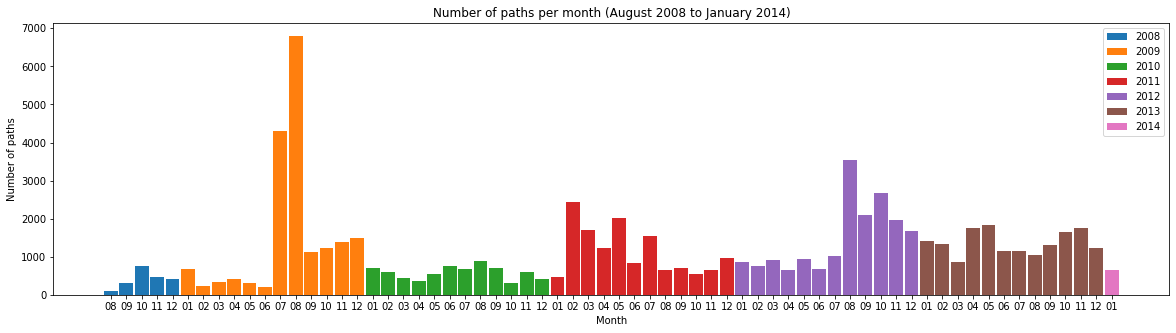

In [44]:
# barplot of the number of path in each month
# groupe by year and month and count
freq_timestamp = all_paths.groupby(["year", "month"], as_index=False).size().reset_index()

# barplot
fig, ax= plt.subplots(1, 1, figsize = (20, 5))
year_color = {"2008": 'lightcoral', "2009": 'lightsalmon', "2010": 'bisque', 
              "2011": 'palegreen', "2012": 'skyblue', "2013": 'lightpink', "2014": 'silver'}
start = 0
for year, color in year_color.items():
    value = freq_timestamp.loc[freq_timestamp["year"] == year]
    b = plt.bar(x = np.arange(start, start + len(value)), height = value["size"], width = 0.9)
    start = start + len(value)
ax.set_xticks(np.arange(66))
ax.set_xticklabels(freq_timestamp["month"])
year_color = {"2008": 'lightcoral', "2009": 'lightsalmon', "2010": 'bisque', 
              "2011": 'palegreen', "2012": 'skyblue', "2013": 'lightpink', "2014": 'silver'}
ax.legend(year_color.keys())
ax.set_title("Number of paths per month (August 2008 to January 2014)")
ax.set_xlabel("Month")
a = ax.set_ylabel("Number of paths")


In [47]:
# find all categories in each path
''' link_categories = pd.read_csv(DATA_PATH + "categories.tsv", sep="\t", header = None, skiprows=13, names = [
    'article',   'categories'
  ])
different_categories = link_categories["categories"].unique()
cat_dataframe = pd.DataFrame(0, index=all_paths.index, columns=different_categories)
for index, path in tzip(all_paths.index, all_paths["path"]):
    path_split = path.split(";")
    for link in path_split:
        if link != "<":
            link_row = link_categories.loc[link_categories["article"] == link]
            for cat in link_row["categories"]:
                cat_dataframe.loc[index][cat] = cat_dataframe.loc[index][cat] + 1      
cat_dataframe.to_pickle("cat_dataframe.pkl") '''

# just load the dataframe saved in a pickle format
cat_dataframe = pd.read_pickle("data/cat_dataframe.pkl")
# a row: index of the path and nb of link with the follwing subject in the path (0 if not)
cat_dataframe.head()

,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain,subject.People.Historical_figures,subject.Countries,subject.Geography.European_Geography.European_Countries,subject.People.Artists,subject.Business_Studies.Currency,subject.History.General_history,subject.History.Military_History_and_War,subject.Science.Physics.Space_Astronomy,subject.Everyday_life.Sports_events,...,subject.History.British_History,subject.IT.Cryptography,subject.Citizenship.Law,subject.History.North_American_History,subject.Citizenship.Culture_and_Diversity,subject.Citizenship.Education,subject.Science.Biology.Evolution_and_reproduction,subject.Science.Chemistry.Materials_science,subject.Science.Physics.The_Planets,subject.Art.Artists
15545,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13719,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
10377,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2510,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# count each occurrence of the topic by grouping it by year to be able to find the most popular topics in each year.
all_paths = pd.concat([all_paths, cat_dataframe], join = 'outer', axis = 1)
path_by_date = all_paths.groupby(["year"]).sum()
path_by_date = path_by_date.drop(columns = "durationInSec")
# a row: for each year, the number of occurrences of each subject in a path.
path_by_date.head()

C:\Users\Emilien\AppData\Local\Temp/ipykernel_5508/3914709558.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  path_by_date = all_paths.groupby(["year"]).sum()


,subject.History.British_History.British_History_1500_and_before_including_Roman_Britain,subject.People.Historical_figures,subject.Countries,subject.Geography.European_Geography.European_Countries,subject.People.Artists,subject.Business_Studies.Currency,subject.History.General_history,subject.History.Military_History_and_War,subject.Science.Physics.Space_Astronomy,subject.Everyday_life.Sports_events,...,subject.History.British_History,subject.IT.Cryptography,subject.Citizenship.Law,subject.History.North_American_History,subject.Citizenship.Culture_and_Diversity,subject.Citizenship.Education,subject.Science.Biology.Evolution_and_reproduction,subject.Science.Chemistry.Materials_science,subject.Science.Physics.The_Planets,subject.Art.Artists
year,,,,,,,,,,,,,,,,,,,,,
2008,52,80,1916,629,37,28,209,79,275,26,...,91,3,54,24,43,41,50,49,203,0
2009,1287,813,16266,5750,270,457,2773,1134,2370,399,...,737,65,444,181,459,452,488,310,1481,0
2010,467,267,6072,2200,103,196,908,480,980,155,...,274,16,129,70,192,189,180,86,637,0
2011,1087,431,10446,3769,155,262,2025,694,2144,245,...,483,36,291,112,362,246,267,157,1161,0
2012,1002,459,12351,4448,184,267,2151,662,2282,357,...,616,35,415,122,379,324,367,171,1509,0


# Spatial analysis